In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")


Set up estimator and its PDF:

In [23]:
def pearson_r(data, axis=0):
    """Compute the Pearson correlation coefficient."""
    x=data[:,0]
    y=data[:,1]
    x_ = x - np.mean(x, axis=axis, keepdims=True)
    y_ = y - np.mean(y, axis=axis, keepdims=True)
    r = np.sum(x_*y_, axis=axis) / (np.sqrt(np.sum(x_**2, axis=axis))*np.sqrt(np.sum(y_**2, axis=axis)))
    return r

def pearson_r_pdf(r, n, rho):
    """Compute the PDF of the Pearson correlation coefficient."""
    # https://mathworld.wolfram.com/CorrelationCoefficientBivariateNormalDistribution.html
    hypergeom = scipy.special.hyp2f1(0.5, 0.5, (2*n-1)/2, (rho*r+1)/2)
    Gamma = scipy.special.gamma
    return (
        (n-2)*Gamma(n-1)*(1-rho**2)**((n-1)/2)*(1-r**2)**((n-4)/2) 
        / (np.sqrt(2*np.pi)*Gamma(n-0.5)*(1-rho*r)**(n-3/2))
        * hypergeom
    )



Create data and estimate the Pearson correlation coefficient:

In [24]:
# Define the covariance matrix for our RVs
rho_inp = 0.5
cov = np.array(
    [[1, rho_inp],
     [rho_inp, 1]]
)
# We use n samples to estimate the correlation coefficient from
n = 100

data = scipy.stats.multivariate_normal(cov=cov).rvs((n))

# estimate pearson_r:

est = pearson_r(data, axis=0)


Define prior, likelihood and combine to posterior:

In [25]:
def prior_rho(rho):
    # Uniform prior rho\simU(-1, 1)
    return np.piecewise(rho, [(rho > -1) & (rho < 1)], [0.5, 0])

def likelihood_rho(est,rho):
    return pearson_r_pdf(est,n,rho)

def posterior_rho(rho,est):
    return prior_rho(rho) * likelihood_rho(est,rho)


Set up bootstrap function and check that the likelihood matches the sampling distribution:

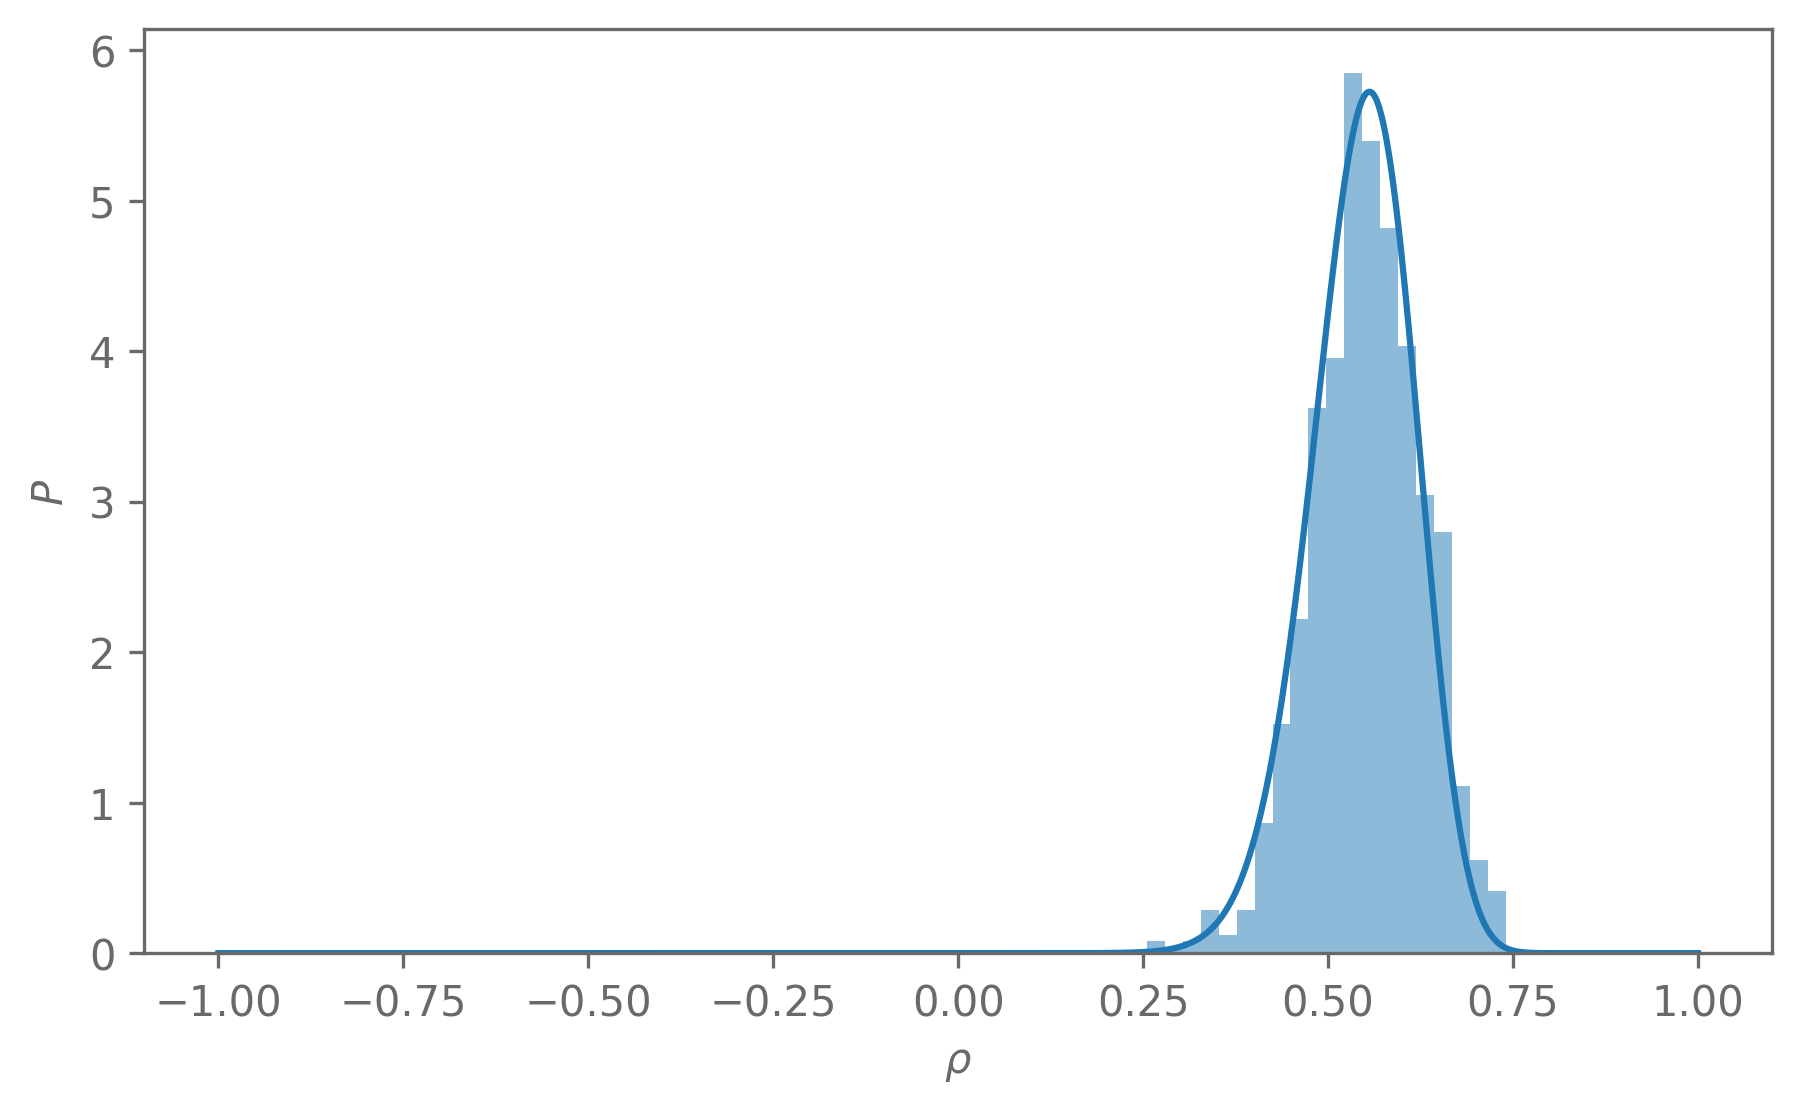

In [28]:
def bootstrap(data, statistic, n_trial):
    n_data = data.shape[0]
    s = []
    for i in range(n_trial):
        idx = np.random.choice(n_data, size=n_data, replace=True)
        data_resampled = data[idx]
        s.append(statistic(data_resampled))
    
    return np.array(s)

rho = np.linspace(-1,1,1000)

# Check that the likelihood matches the sampling distribution with a bootstrap:
bootstrap_samples = bootstrap(data,pearson_r,1000)

plt.hist(bootstrap_samples,density=True,bins=20,alpha=0.5)
plt.plot(rho,likelihood_rho(est,rho),color='C0')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P$');


Now calculate a posterior given our estimate of the Pearson correlation coefficient of n data points:

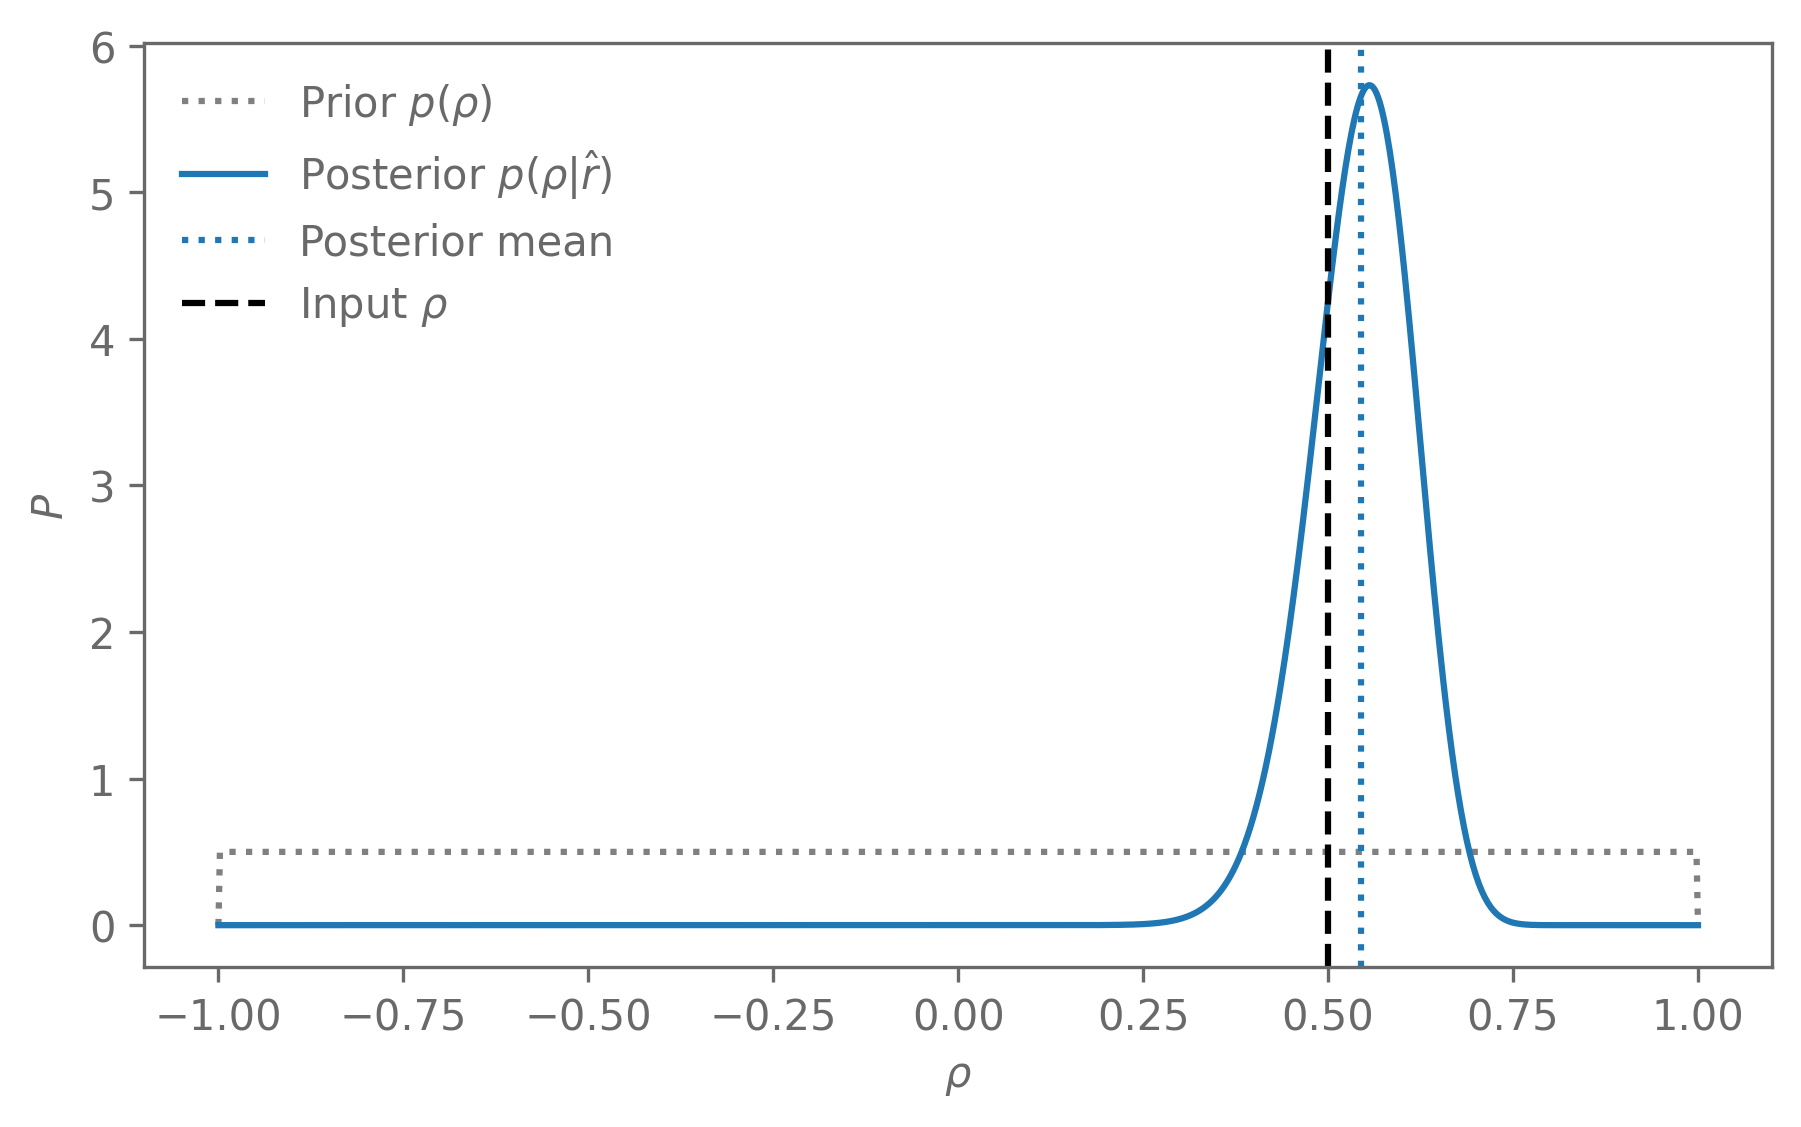

In [29]:

norm = np.trapz(posterior_rho(rho,est),x=rho)
mean = np.trapz(rho * posterior_rho(rho,est)/norm,x=rho)

plt.plot(rho,prior_rho(rho),c="grey", ls=":", label=r"Prior $p(\rho)$")
plt.plot(rho,posterior_rho(rho,est)/norm,label=r'Posterior $p(\rho \vert \hat{r} )$')
plt.axvline(mean,color='C0',linestyle='dotted',label=r'Posterior mean')
plt.axvline(rho_inp,linestyle='dashed',color='black',label=r'Input $\rho$')
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel(r'$\rho$');

Note that this works much better if the number of data points n is increased